⚠️⚠️⚠️⚠️This notebook needs swithing to GPU.
This note book is only suit for protein with a single chain for the moment.

# 👋 Hi there.你好👋
This is for a general simulation for a RCSB PDB structures with ligand bound. This notebook is only suggested for a single-chained protein ligand system for the moment.

This notebook take http://zarbi.chem.yale.edu/ligpargen/namd_tutorial.html as a reference. This notebook is wrritten by quantaosun@gmail.com in Shanghai, China, 2021. 


-------------------------------------------------------------------------
When you see a ⚠️ or ⚠️⚠️， that is where eithter need you to do some extra work out of this notebook  or a reminder it is easy to go wrong.
-------------------------------------------------------------------------

---



# The tutorial uses an example structure of 2-propylphenol in complex with T4 lysozyme L99A/M102Q (PDB ID: 3HTB.pdb)

**The overall procedure is as below**

1.   Installation of Anaconda,pymol, vmd, and openmm, pdbfixer
2.   PDB ID provided by user
3.   Separation of ligand and protein
4.   Topology generation for ligand using LigParGen web server
5.   Combine new ligand pdb and original protein, mannually renumber ligand atom
6.   Generation of ionized.pdb and ionized.psf by VMD, with Charmm force field.
7.   Generation of conf file for NAMD simulation. 
8.   GPU accelerted NAMD simulation and copy simualtion data to google drive.


In [1]:
#@title 👋Mount to Goole Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#@title 👋 1.Install Dependencies, this could take a while.
from IPython.utils import io
import os
import subprocess
import tqdm.notebook

TQDM_BAR_FORMAT = '{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]'

try:
  with tqdm.notebook.tqdm(total=100, bar_format=TQDM_BAR_FORMAT) as pbar:
    with io.capture_output() as captured:
      # Uninstall default Colab version of TF.
      !mkdir external-libraries &> /dev/null
      ! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh &> /dev/null
      ! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh &> /dev/null
      ! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /home/aistudio/external-libraries &> /dev/null
      #@title Install Pymol
      pbar.update(6)
      ! yes | /home/aistudio/external-libraries/bin/conda install -c conda-forge vmd &> /dev/null
      #@title Install VMD
      !yes | /home/aistudio/external-libraries/bin/conda install -c conda-forge pymol-open-source &> /dev/null
      #install openmm
      !yes | /home/aistudio/external-libraries/bin/conda install -c conda-forge openmm &> /dev/null
      #install pdbfixer
      pbar.update(2)
      !yes | /home/aistudio/external-libraries/bin/conda install -c conda-forge pdbfixer &> /dev/null
      #install visualization
      pbar.update(9)
      ! /home/aistudio/external-libraries/bin/pip install py3Dmol &> /dev/null
      # pip install pdb-tools
      ! /home/aistudio/external-libraries/bin/pip install pdb-tools &> /dev/null
      #install visualization
      !yes | /home/aistudio/external-libraries/bin/conda install -c rdkit rdkit &> /dev/null
      #install csh shell for step 8 or step 9
      pbar.update(80)
      !apt-get install csh &> /dev/null
      !apt-get install vim &> /dev/null
      pbar.update(2)
      import sys
      sys.path.append('/home/aistudio/external-libraries/lib/python3.7/')
      import sys
      sys.path.append('/home/aistudio/external-libraries/lib/python3.7/site-packages/')
      #import rdkit for visualization purpose
      from rdkit import Chem
      from rdkit.Chem import AllChem
      from rdkit.Chem import Draw
      from rdkit.Chem.Draw import IPythonConsole
      from rdkit.Chem import DataStructs
      from rdkit.Chem import RDConfig
      from rdkit.Chem import rdBase
      from rdkit.Chem import MolFromPDBFile
      import py3Dmol
      pbar.update(1)
except subprocess.CalledProcessError:
  print(captured)
  raise

  0%|          | 0/100 [elapsed: 00:00 remaining: ?]

In [ ]:
#@title 👋 2.Input a PDB id. This will download the PDB, then fix broken backbone, change all non-standard residues to standard version.
complex = "3htb" #@param {type:"string"}
pdb = complex + ".pdb"
!wget http://www.pdb.org/pdb/files/'{pdb}'
!/home/aistudio/external-libraries/bin/pdbfixer  '{pdb}' --ph=7  --replace-nonstandard --add-residues

# 👋  3.Download output.pdb, use your local pymol to split protein.pdb and ligand.pdb. then upload protein.pdb here while ligand.pdb should be subject to next step.

# 👋 ⚠️4.Uplaod ligand.pdb to LigParGen to generate PDB,PRM and RTF three files. Then upload them here.
http://zarbi.chem.yale.edu/ligpargen/index.html 

# 👋 ⚠️. 5 Use Pymol to drag the splitted protein and the ligand PDB file generated by LigParGen, save them together, to combine it as a complex.pdb U[load comple.pdb here. 

In [3]:
#@title 6 👋Download Charmm Force Field
!wget https://raw.githubusercontent.com/quantaosun/NAMD-MD/main/top_all36_prot.prm 
!wget https://raw.githubusercontent.com/quantaosun/NAMD-MD/main/top_all36_prot.rtf 
!wget https://raw.githubusercontent.com/quantaosun/NAMD-MD/main/toppar_water_ions.mod.str

--2021-10-31 12:28:55--  https://raw.githubusercontent.com/quantaosun/NAMD-MD/main/top_all36_prot.prm
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 186579 (182K) [text/plain]
Saving to: ‘top_all36_prot.prm’

top_all36_prot.prm  100%[===================>] 182.21K  --.-KB/s    in 0.02s   

2021-10-31 12:28:56 (7.41 MB/s) - ‘top_all36_prot.prm’ saved [186579/186579]

--2021-10-31 12:28:56--  https://raw.githubusercontent.com/quantaosun/NAMD-MD/main/top_all36_prot.rtf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72977 (71K) [text

# 7. you could refer to http://zarbi.chem.yale.edu/ligpargen/namd_tutorial.html to use local VMD to produce the key PSF and PDB file needed for a NAMD simulation. THis step is tricky, please double check if ionized.pdb actually contains your small molecule. Alternatively, you could use next command line, but I recomend beginners use graphical VMD aut psfgen plugin.

In [ ]:
#@title  👋 8.If you have successfully generated ionized.pdb, you can skip this step.
RTF_name = "JZ4_5F6E51" #@param {type:"string"}
#Download opls amino acid topology file.
com_file = open('psfgen.pgn','w')
com_file.write('''
package require psfgen   
topology top_all36_prot.rtf
topology BNZ.rtf 

pdbalias HIS HSD
pdbalias atom SER HG HG1
pdbalias residue HIS HSE     
pdbalias atom ILE CD1 CD

segment A {pdb complex.pdb}  
coordpdb complex.pdb A   
guesscoord   
writepdb complex_autopsf.pdb     
writepsf complex_autopsf.psf 

package require solvate  
solvate complex_autopsf.psf complex_autopsf.pdb -t 5 -o complex_wb 
package require autoionize
autoionize -psf complex_wb.psf -pdb complex_wb.pdb -neutralize -o ionized
set ubq [atomselect top all]
measure minmax $ubq  
measure center $ubq   
exit    
''')
com_file.close()
!sed -i "s/BNZ/{RTF_name}/g" psfgen.pgn
!/home/aistudio/external-libraries/bin/vmd -dispdev text -e psfgen.pgn

In [7]:
#@title 👋 ⚠️9.Download NAMD confiles and then manually modify the ligand parameter path, and modify PBC conditions based on water box dimensions outputed from previous step.

!wget https://raw.githubusercontent.com/quantaosun/NAMD-MD/main/nvt.namd 
!wget https://raw.githubusercontent.com/quantaosun/NAMD-MD/main/npt.namd


--2021-10-31 12:50:53--  https://raw.githubusercontent.com/quantaosun/NAMD-MD/main/nvt.namd
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2231 (2.2K) [text/plain]
Saving to: ‘nvt.namd’

nvt.namd            100%[===================>]   2.18K  --.-KB/s    in 0s      

2021-10-31 12:50:53 (55.6 MB/s) - ‘nvt.namd’ saved [2231/2231]

--2021-10-31 12:50:53--  https://raw.githubusercontent.com/quantaosun/NAMD-MD/main/npt.namd
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4497 (4.4K) [text/plain]
Saving to: ‘npt.namd’

npt.namd       

[链接文字](`https://`)Modify configuration file
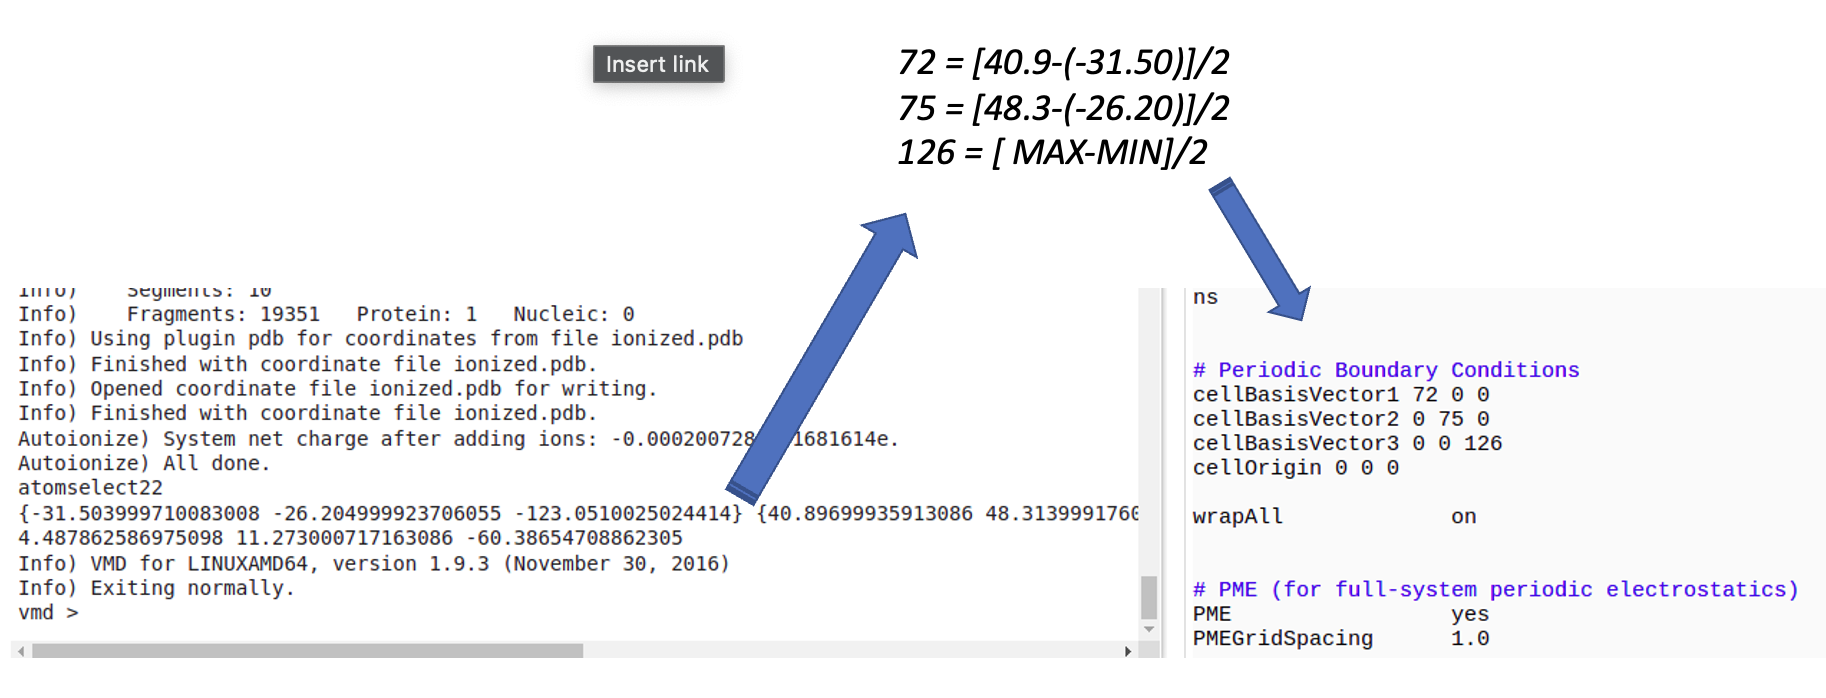


In [8]:
#@title 👋 10.Import NAMD software. You are supposed to have the NAMD software.
NAMD_tarball_PATH = "/content/drive/MyDrive/softwares/NAMD_3.0alpha8_Linux-x86_64-multicore-CUDA-SingleNode.tar.gz" #@param {type:"string"}

!tar -xvf '{NAMD_tarball_PATH}' &> /dev/null


In [10]:
#@title 👋 11.Run the Simulation and Copy result back to Goolge Drive
Path = "/content/drive/MyDrive/NAMD-MD" #@param {type:"string"}

!/content/NAMD_3.0alpha8_Linux-x86_64-multicore-CUDA/namd3 +p2 nvt.namd > nvt.log
!/content/NAMD_3.0alpha8_Linux-x86_64-multicore-CUDA/namd3 +p2 npt.namd > npt.log &&


^C
/bin/bash: -c: line 1: syntax error: unexpected end of file
